# 24x24 Image Generation GAN

In [ ]:
# Thanks to https://medium.com/analytics-vidhya/create-your-own-real-image-dataset-with-python-deep-learning-b2576b63da1e


#importing the libraries
import os 
import cv2
import random
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline
import tensorflow as tf
#from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape

In [ ]:
#setting the path to the directory containing the pics
path = '.'
#appending the pics to the training data list
training_data = []
for img in os.listdir(path):
    if img[-5:] != ".jpeg":
        continue
    pic = cv2.imread(os.path.join(path,img))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(24,24))
    training_data.append([pic])

In [ ]:
path = '.'

In [ ]:
#converting the list to numpy array and saving it to a file using #numpy.save
np.save(os.path.join(path,'features'),np.array(training_data))

In [ ]:
#loading the saved file once again
saved = np.load(os.path.join(path,'features.npy'))

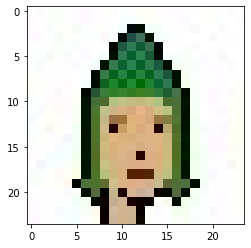

In [ ]:
pyplot.imshow(saved[0].reshape(24,24,3))

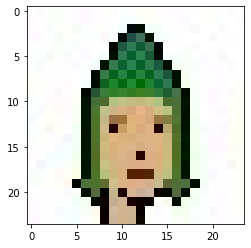

In [ ]:
pyplot.imshow(np.array(training_data[0][0]).reshape(24,24,3))

In [ ]:
# Thanks also to https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [ ]:
newData = []
training_data[0][0].tolist()
for i in range(len(training_data)):
  newData += [training_data[i][0].tolist()]

In [ ]:
# # example of loading the cifar10 dataset
# from keras.datasets.cifar10 import load_data
# # load the images into memory
# (trainX, trainy), (testX, testy) = load_data()
# # summarize the shape of the dataset
# print('Test', testX.shape, testy.shape)
trainX = np.array(newData)
print('Train', trainX.shape)

Train (1501, 24, 24, 3)


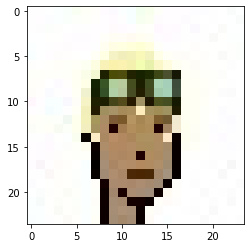

In [ ]:
# plot raw pixel data
pyplot.imshow(trainX[i])

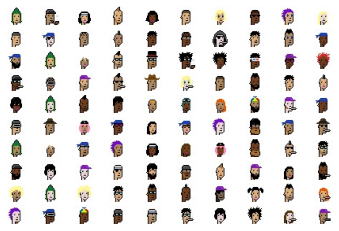

In [ ]:
# plot images from the training dataset
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])
pyplot.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6, 6, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 256)         2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


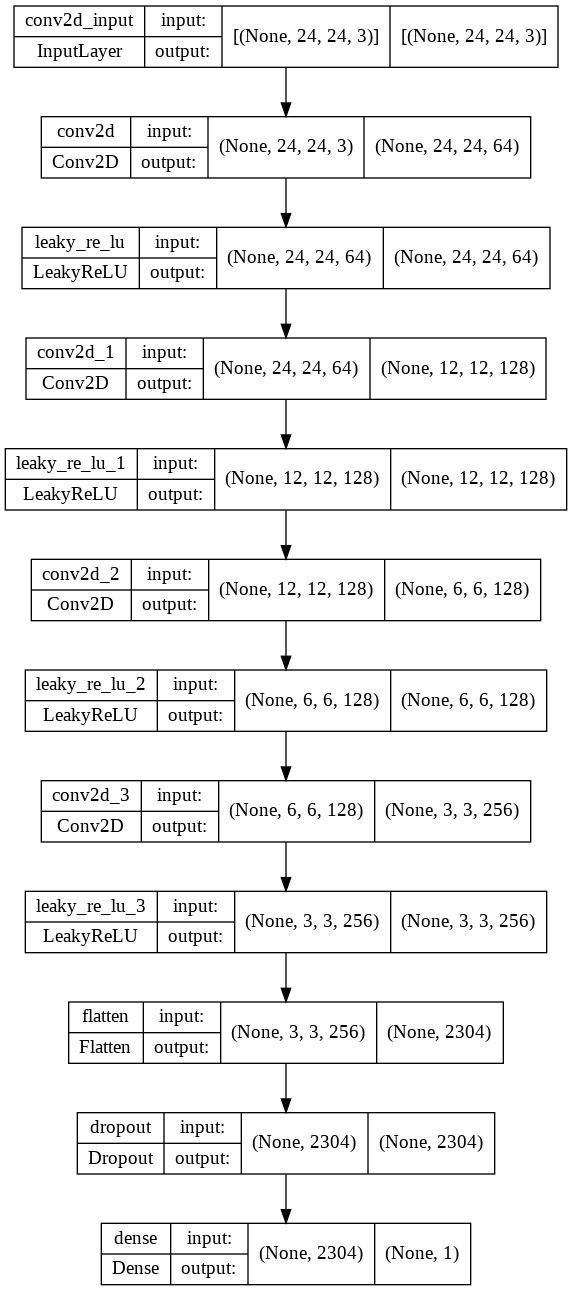

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(24,24,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
tf.keras.utils.plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [ ]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = np.random.rand(24 * 24 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 24, 24, 3))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1 real=59% fake=3%
>2 real=100% fake=11%
>3 real=100% fake=23%
>4 real=100% fake=38%
>5 real=100% fake=59%
>6 real=100% fake=94%
>7 real=100% fake=100%
>8 real=100% fake=100%
>9 real=100% fake=100%
>10 real=100% fake=100%
>11 real=100% fake=100%
>12 real=100% fake=100%
>13 real=98% fake=100%
>14 real=100% fake=100%
>15 real=98% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2304)              232704    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 2304)              0         
                                                                 
 reshape (Reshape)           (None, 3, 3, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 6, 6, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6, 6, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 12, 12, 128)      262272    
 ranspose)                                            

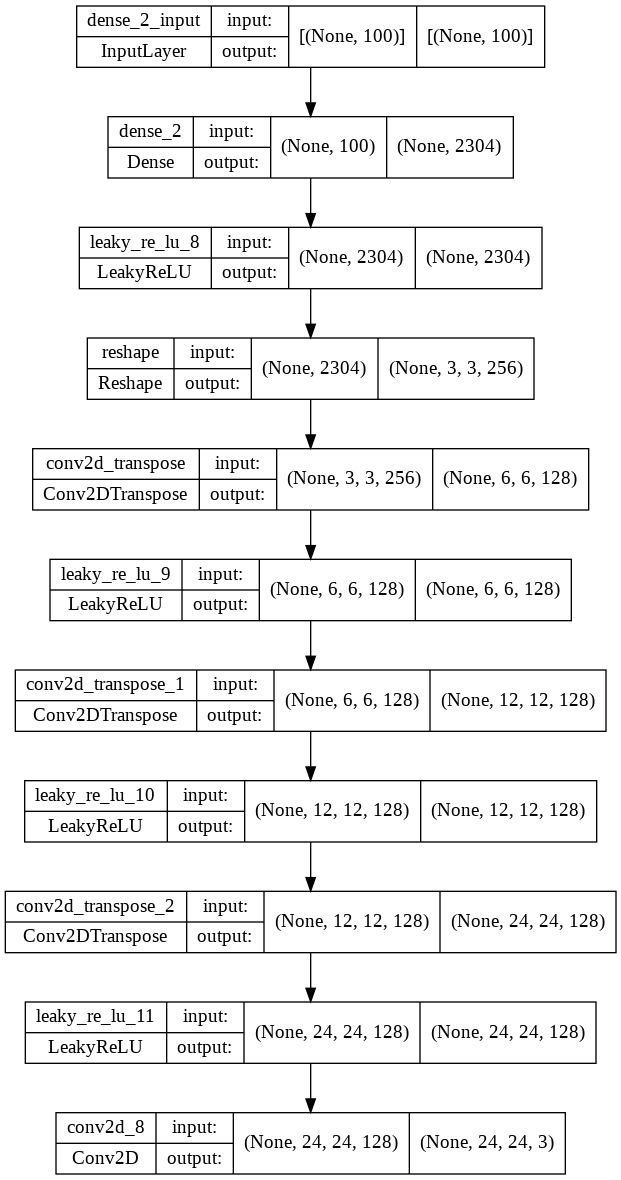

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 3x3 image
	n_nodes = 256 * 3 * 3
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((3, 3, 256)))
	# upsample to 6x6
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 12x12
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 24x24
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model
 
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
tf.keras.utils.plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

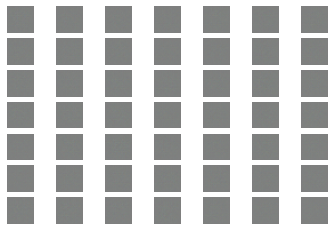

In [ ]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i])
# show the figure
pyplot.show()

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 24, 24, 3)         1285123   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 520705    
                                                                 
Total params: 1,805,828
Trainable params: 1,285,123
Non-trainable params: 520,705
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


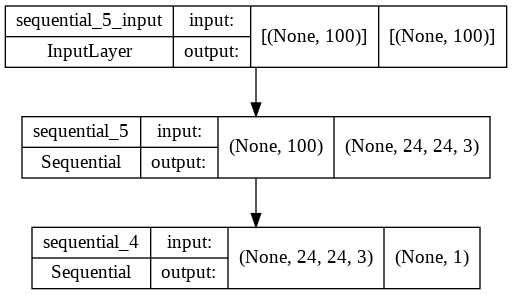

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
tf.keras.utils.plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/11, d1=0.698, d2=0.695 g=0.692
>1, 2/11, d1=0.553, d2=0.697 g=0.690
>1, 3/11, d1=0.436, d2=0.701 g=0.686
>1, 4/11, d1=0.311, d2=0.709 g=0.679
>1, 5/11, d1=0.203, d2=0.722 g=0.669
>1, 6/11, d1=0.111, d2=0.742 g=0.659
>1, 7/11, d1=0.061, d2=0.758 g=0.659
>1, 8/11, d1=0.040, d2=0.757 g=0.675
>1, 9/11, d1=0.035, d2=0.734 g=0.717
>1, 10/11, d1=0.035, d2=0.677 g=0.784
>1, 11/11, d1=0.034, d2=0.626 g=0.846
>2, 1/11, d1=0.035, d2=0.602 g=0.854
>2, 2/11, d1=0.031, d2=0.618 g=0.817
>2, 3/11, d1=0.031, d2=0.643 g=0.770
>2, 4/11, d1=0.018, d2=0.670 g=0.741
>2, 5/11, d1=0.014, d2=0.697 g=0.718
>2, 6/11, d1=0.015, d2=0.727 g=0.700
>2, 7/11, d1=0.014, d2=0.741 g=0.707
>2, 8/11, d1=0.015, d2=0.706 g=0.754
>2, 9/11, d1=0.012, d2=0.631 g=0.848
>2, 10/11, d1=0.012, d2=0.565 g=0.933
>2, 11/11, d1=0.020, d2=0.551 g=0.949
>3, 1/11, d1=0.015, d2=0.566 g=0.960
>3, 2/11, d1=0.021, d2=0.543 g=1.013
>3, 3/11, d1=0.038, d2=0.491 g=1.058
>3, 4/11, d1=0.019, d2=0.455 g=1.094
>3, 5/11, d1=0.014, d2=0.429 g=1.1

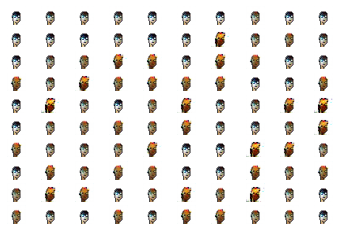

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
 
# load model
model = tf.keras.models.load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

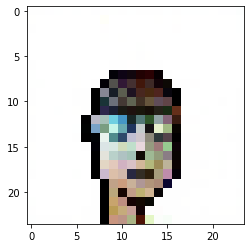

In [ ]:
# load model
model = tf.keras.models.load_model('generator_model_200.h5')
# all 0s
vector = np.asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()

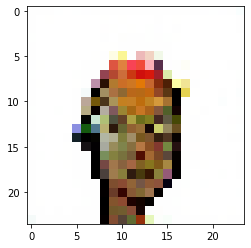

In [ ]:
# load model
model = tf.keras.models.load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
for i in range(12):
  pyplot.imshow(X[i, :, :])